In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import webuiapi


# WFLWのアノテーションデータの読み込み
annotation_data_path = "/root/dataset/WFLW/WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_train.txt"
WFLW_images = "/root/dataset/WFLW/WFLW_images"

with open(annotation_data_path) as f:
    anotation_data = f.readlines()
anotation_data_lists = []
for i in anotation_data:
    anotation_data_lists.append(i.split(" ")) # アノテーションデータと画像のファイルパスが全て入ったリスト

390
562
face_center 501.0 589.0
image_size: 376.2
(124.80000000000001, 212.8, 877.2, 965.2)
bounding_box_data (306, 308, 696, 870)
[184.507007 193.057345 197.471739 194.783872 189.965287 188.508619
 190.848163 197.726266 207.080068 217.287363]
[325.569019 347.320847 370.214395 393.349851 416.215727 439.53149
 462.758182 485.076907 506.501121 527.536765]
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x1024 at 0x7FA115295E50>


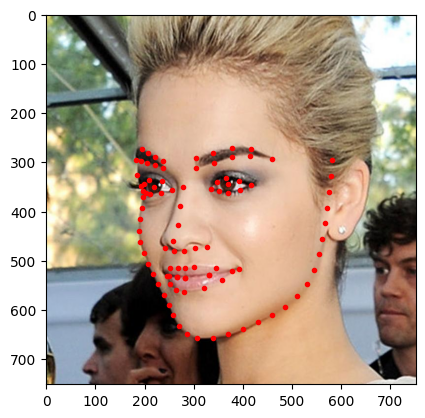

In [30]:
# controlnet input imageの作成

image_num = 0
# for image_num in range(0,20):
# 入力画像の加工
image_path = WFLW_images + "/" + anotation_data_lists[image_num][-1].replace("\n","")
bounding_box_data = tuple([int(bdbox) for bdbox in anotation_data_lists[image_num][-11:-7]])
fig, ax = plt.subplots(1)
image = Image.open(image_path)
# 顔画像のバウンディングボックスのサイズ
face_width = bounding_box_data[2]-bounding_box_data[0]
face_height = bounding_box_data[3]-bounding_box_data[1]
print(face_width)
print(face_height)
#顔の中心座標
face_center_x = float((bounding_box_data[2]+bounding_box_data[0]) / 2)
face_center_y = float((bounding_box_data[3]+bounding_box_data[1]) / 2)
print("face_center",face_center_x,face_center_y)

# クロップサイズの決定
margin = float((face_width+face_height) / 2 * 0.2)
half_long_side = max(face_width,face_height) / 2
image_size = margin + half_long_side
print("image_size:",image_size)
crop_size = (
    face_center_x-image_size,
    face_center_y-image_size,
    face_center_x+image_size,
    face_center_y+image_size
)
print(crop_size)
control_image = image.crop(crop_size)
ax.imshow(control_image)

# ランドマーク座標の加工
crop_keypoints_x = [float(keypoint) - crop_size[0] for keypoint in anotation_data_lists[image_num][0:196:2]]
crop_keypoints_y = [float(keypoint) - crop_size[1] for keypoint in anotation_data_lists[image_num][1:196:2]]
print("bounding_box_data",bounding_box_data)
x_np = np.array(crop_keypoints_x)
y_np = np.array(crop_keypoints_y)

# print(x_np[0:10])
# print(y_np[0:10])
# print(image)
# plt.plot(x_np, y_np, 'o',color='red',markersize=3)  # 点と点を線でつなぐプロットを作成
# plt.show()

出力画像サイズ (512, 512)


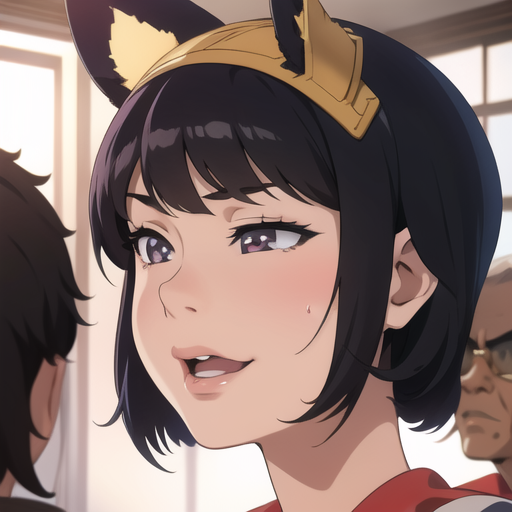

In [27]:
# stable diffusion api
prompt = "1girl,face,beautiful,masterpiece,anime"
negative_prompt = "lowres, (worst quality:1.5), (low quality:1.5), normal quality, text, watermark"
# fig, ax = plt.subplots(1)
api = webuiapi.WebUIApi(host='10.8.76.222', port=7860) # control_image
unit1 = webuiapi.ControlNetUnit(
    input_image=control_image,
    module='openpose_faceonly',
    model='control_v11p_sd15_openpose [cab727d4]',
    weight=2
)
r = api.txt2img(
    prompt=prompt,
    negative_prompt=negative_prompt,
    width=512,
    height=512,
    steps=20,
    controlnet_units=[unit1]
)
# print("出力画像サイズ",r.image.size)
# r.image

In [29]:
image_size

376.2

[125.55500742 131.37341925 134.37736625 132.54830205 129.26930747
 128.27806078 129.87009497 134.5505691  140.91572942 147.86168242]
[221.54616923 236.34805112 251.92686103 267.6702867  283.23026611
 299.09638873 314.9018995  330.08954862 344.66849276 358.98301925]


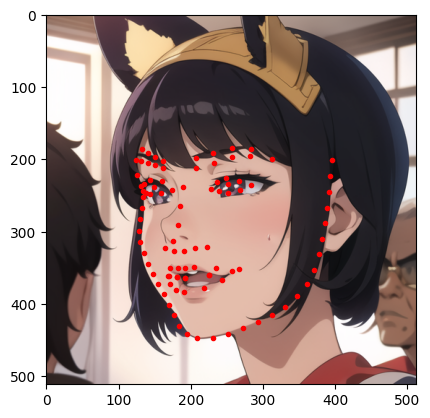

In [32]:
genimage_keypoints_x = [float(keypoint_x * (512 / (image_size*2))) for keypoint_x in crop_keypoints_x]
genimage_keypoints_y = [float(keypoint_y * (512 / (image_size*2))) for keypoint_y in crop_keypoints_y]
x_np = np.array(genimage_keypoints_x)
y_np = np.array(genimage_keypoints_y)
print(x_np[0:10])
print(y_np[0:10])
fig,ax = plt.subplots(1)
ax.imshow(r.image)
plt.plot(x_np, y_np, 'o',color='red',markersize=3)  # 点と点を線でつなぐプロットを作成
plt.show()